In [1]:
import numpy as np
from heapq import heappush, heappop
from numba import njit, prange, boolean
from numba.core import types
from numba.typed import Dict

In [2]:
float_array = types.f8[:]
@njit(parallel=True)
def gen_graph_compiled(nverts=3e3, dims=3):
    vertices = np.array([(np.float64(0),np.float64(0),np.float64(0))]*nverts)
    for i in prange(nverts):
        vertices[i] = np.random.uniform(0, 1, dims)
    return vertices
        

In [3]:
int_array = types.i8[:]
@njit
def choose_edges_compiled(vertices: Dict, min_connections=2, max_connections=-1):
    edges = Dict.empty(
        key_type = types.i8,
        value_type = int_array
    )
    for i in range(len(vertices)):
        other_verts = np.array(list(range(len(vertices))))
        nedges = min_connections
        these_edges = np.random.choice(other_verts, nedges, replace=False)
        edges[i] = these_edges
        for j in these_edges:
            if (j in list(edges.keys())):
                edges[j] = np.concatenate((edges[j],np.array([i])))
            else:
                edges[j] = np.array([i])

    return edges
    

In [4]:
def get_mindist(dist, Q):
    dists = np.empty(len(dist), np.float64)
    for i in range(dists.shape[0]):
        a = boolean(i in Q)
        dists[i] = dist[i] * a + np.float64(1e9) * (1-a)
    return np.argmin(dists)
            

def dijkstra_p(verts, edges, source, target):
    dist = {}
    prev = {}
    Q = list(range(len(verts)))
    for v in Q:
        dist[v] = np.float64(1e9)
        prev[v] = -1
    dist[source] = 0
    while len(Q):
        u = get_mindist(dist, Q)
        Q.remove(u)
        if u == target:
            return dist, prev
        for i in range(len(edges[u])):
            v = edges[u][i]
            alt = dist[u] + np.linalg.norm(verts[u] - verts[v])
            a = boolean(alt < dist[v])
            dist[v] = alt * a + dist[v] * (1-a)
            prev[v] = u * a + prev[v] * (1-a)
    return dist, prev

In [5]:
@njit
def get_mindist_c(dist, Q):
    dists = np.empty(len(dist), np.float64)
    for i in range(dists.shape[0]):
        a = boolean(i in Q)
        dists[i] = dist[i] * a + np.float64(1e9) * (1-a)
    return np.int64(np.argmin(dists))

@njit
def dijkstra_c(verts, edges, source, target):
    dist = Dict.empty(
        key_type = types.i8,
        value_type = types.f8
    )
    prev = Dict.empty(
        key_type = types.i8,
        value_type = types.i8
    )
    Q = list(range(len(verts)))
    for v in Q:
        dist[v] = np.float(1e9)
        prev[v] = np.int64(-1)
    dist[source] = 0
    while len(Q):
        u = get_mindist_c(dist, Q)
        Q.remove(u)
        if u == target:
            return dist, prev
        for i in range(len(edges[u])):
            v = edges[u][i]
            alt = dist[u] + np.linalg.norm(verts[u] - verts[v])
            a = boolean(alt < dist[v])
            dist[v] = alt * a + dist[v] * (1-a)
            prev[v] = u * a + prev[v] * (1-a)
    return dist, prev

In [6]:
@njit(parallel=True)
def get_mindist_cp(dist, Q):
    dists = np.empty(len(dist), np.float64)
    for i in prange(dists.shape[0]):
        a = boolean(i in Q)
        dists[i] = dist[i] * a + np.float64(1e9) * (1-a)
    return np.int64(np.argmin(dists))

@njit(parallel=True)
def dijkstra_cp(verts, edges, source, target):
    dist = Dict.empty(
        key_type = types.i8,
        value_type = types.f8
    )
    prev = Dict.empty(
        key_type = types.i8,
        value_type = types.i8
    )
    Q = list(range(len(verts)))
    for v in Q:
        dist[v] = np.float(1e9)
        prev[v] = np.int64(-1)
    dist[source] = 0
    while len(Q):
        u = get_mindist_cp(dist, Q)
        Q.remove(u)
        if u == target:
            return dist, prev
        for i in prange(len(edges[u])):
            v = edges[u][i]
            alt = dist[u] + np.linalg.norm(verts[u] - verts[v])
            a = boolean(alt < dist[v])
            dist[v] = alt * a + dist[v] * (1-a)
            prev[v] = u * a + prev[v] * (1-a)
    return dist, prev

In [7]:
def dijkstra_pq(verts, edges, source, target):
    dist = np.array([1e9]*(len(verts)))
    prev = np.array([-1]*(len(verts)))
    dist[source] = 0
    Q = [(0, source)]
    while len(Q):
        u = heappop(Q)[1]
        if u == target:
            return dist, prev
        for v in edges[u]:
            alt = dist[u] + np.linalg.norm(verts[u] - verts[v])
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
                heappush(Q, (dist[v], v))
    return dist, prev

In [8]:
@njit
def dijkstra_cq(verts, edges, source, target):
    dist = np.array([np.float64(1e9)]*(len(verts)))
    prev = np.array([-1]*(len(verts)))
    dist[source] = np.float64(0)
    Q = [(np.float64(0), source)]
    while len(Q):
        u = heappop(Q)[1]
        if u == target:
            return dist, prev
        for v in edges[u]:
            alt = dist[u] + np.linalg.norm(verts[u] - verts[v])
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
                heappush(Q, (dist[v], v))
    return dist, prev

In [9]:
def path_dijkstra(prev, source, target):
    s = []
    u = target
    while u != source:
        s.append(u)
        u = prev[u]
    s.append(source)
    return s

In [10]:
from time import perf_counter_ns
vertex_choices = [10, 10, 30, 100, 300, 1000, 3000, 10000]
times_p = []
times_c = []
times_cp = []
times_pq = []
times_cq = []
for choice in vertex_choices:
    print(f'Simulating {choice} 3d vertices within unit cube with random edges')
    vert = gen_graph_compiled(choice)
    edge = choose_edges_compiled(vert)
    source, target = np.random.choice(list(range(len(vert))), 2, False)
    print(f'Source vertex: {source}, {vert[source]}')
    print(f'Target vertex: {target}, {vert[target]}')
    start_p = perf_counter_ns()
    dist_p, prev_p = dijkstra_p(vert, edge, source, target)
    times_p.append((perf_counter_ns() - start_p)/1e6)
    start_c = perf_counter_ns()
    dist_c, prev_c = dijkstra_c(vert, edge, source, target)
    times_c.append((perf_counter_ns() - start_c)/1e6)
    start_cp = perf_counter_ns()
    dist_cp, prev_cp = dijkstra_cp(vert, edge, source, target)
    times_cp.append((perf_counter_ns() - start_c)/1e6)
    start_pq = perf_counter_ns()
    dist_pq, prev_pq = dijkstra_pq(vert, edge, source, target)
    times_pq.append((perf_counter_ns() - start_pq)/1e6)
    start_cq = perf_counter_ns()
    dist_cq, prev_cq = dijkstra_cq(vert, edge, source, target)
    times_cq.append((perf_counter_ns() - start_cq)/1e6)
    

Simulating 10 3d vertices within unit cube with random edges
Source vertex: 5, [0.43226127 0.73096348 0.92281141]
Target vertex: 0, [0.88383938 0.49621293 0.58717894]


<ipython-input-6-eaf88cfb7be7>:25: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  u = get_mindist_cp(dist, Q)


Simulating 10 3d vertices within unit cube with random edges
Source vertex: 5, [0.34915352 0.02739964 0.83578147]
Target vertex: 2, [0.79813465 0.00807183 0.01978186]
Simulating 30 3d vertices within unit cube with random edges
Source vertex: 13, [0.51758632 0.57363084 0.32295542]
Target vertex: 4, [0.34669025 0.38607887 0.49504221]
Simulating 100 3d vertices within unit cube with random edges
Source vertex: 82, [0.12049545 0.02486669 0.43940189]
Target vertex: 10, [0.08420694 0.07081778 0.03095456]
Simulating 300 3d vertices within unit cube with random edges
Source vertex: 69, [0.12739859 0.60118627 0.37627365]
Target vertex: 135, [0.07579184 0.87438011 0.26272206]
Simulating 1000 3d vertices within unit cube with random edges
Source vertex: 237, [0.3923855  0.89373256 0.08428274]
Target vertex: 587, [0.25558778 0.64577896 0.14927144]
Simulating 3000 3d vertices within unit cube with random edges
Source vertex: 465, [0.28746267 0.332124   0.8776043 ]
Target vertex: 515, [0.03483424 0

In [11]:
path_p = path_dijkstra(prev_p, source, target)
path_pq = path_dijkstra(prev_pq, source, target)
path_cq = path_dijkstra(prev_cq, source, target)
path_c = path_dijkstra(prev_c, source, target)
path_cp = path_dijkstra(prev_cp, source, target)

In [12]:
def path_distance(path, vertices:np.array):
    source = path[0]
    dist = 0
    for i, x in enumerate(path):
        if i == 0:
            continue
        else:
            dist += np.linalg.norm(vertices[path[i]] - vertices[path[i-1]])
    return dist

In [13]:
paths = [globals()[f'path_{f}'] for f in ['p', 'pq', 'cq', 'c', 'cp']]

In [14]:
for i, x in enumerate(paths):
    assert paths[i] == paths[0]

In [15]:
path_distance(path_p, vert)

3.3997492150622075

In [16]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def time_regression(nverts, times, c):
    X = np.vstack((np.array(np.log(nverts)),np.array([np.log(x)**2 for x in nverts]))).T
    lm = LinearRegression().fit(X[1:], np.log(times[1:]))
    predict = lm.predict(X[1:])
    plt.plot(X[1:,0], predict, c, ls='--')
    #plt.plot(X[1:,0], np.log(times[1:]), c, ls='-')
    return predict
    

3254.3658781360277


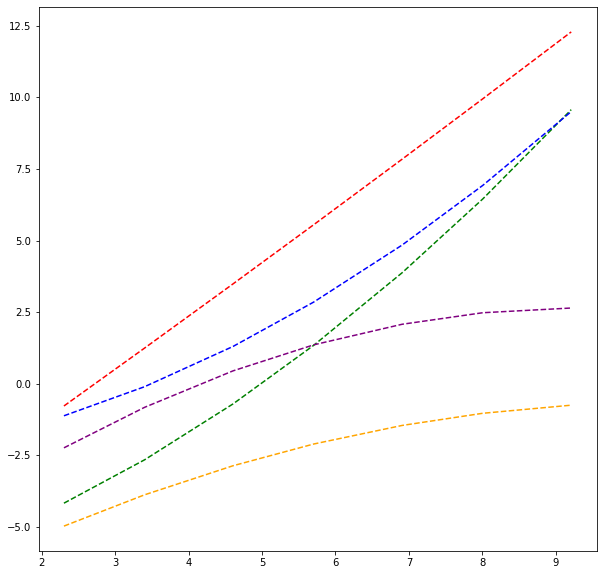

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
pure = time_regression(vertex_choices, times_p, 'red')
compiled = time_regression(vertex_choices, times_c, 'green')
compiled_parallel = time_regression(vertex_choices, times_cp, 'blue')
pure_queue = time_regression(vertex_choices, times_pq, 'purple')
compiled_queue =  time_regression(vertex_choices, times_cq, 'orange')
print(np.exp(pure.mean()-compiled_queue.mean()))

In [18]:
import ast
import dis

In [20]:
dis.dis(dijkstra_p)

 10           0 BUILD_MAP                0
              2 STORE_FAST               4 (dist)

 11           4 BUILD_MAP                0
              6 STORE_FAST               5 (prev)

 12           8 LOAD_GLOBAL              0 (list)
             10 LOAD_GLOBAL              1 (range)
             12 LOAD_GLOBAL              2 (len)
             14 LOAD_FAST                0 (verts)
             16 CALL_FUNCTION            1
             18 CALL_FUNCTION            1
             20 CALL_FUNCTION            1
             22 STORE_FAST               6 (Q)

 13          24 LOAD_FAST                6 (Q)
             26 GET_ITER
        >>   28 FOR_ITER                26 (to 56)
             30 STORE_FAST               7 (v)

 14          32 LOAD_GLOBAL              3 (np)
             34 LOAD_METHOD              4 (float64)
             36 LOAD_CONST               1 (1000000000.0)
             38 CALL_METHOD              1
             40 LOAD_FAST                4 (dist)
           

In [21]:
dis.dis(dijkstra_pq)

  2           0 LOAD_GLOBAL              0 (np)
              2 LOAD_METHOD              1 (array)
              4 LOAD_CONST               1 (1000000000.0)
              6 BUILD_LIST               1
              8 LOAD_GLOBAL              2 (len)
             10 LOAD_FAST                0 (verts)
             12 CALL_FUNCTION            1
             14 BINARY_MULTIPLY
             16 CALL_METHOD              1
             18 STORE_FAST               4 (dist)

  3          20 LOAD_GLOBAL              0 (np)
             22 LOAD_METHOD              1 (array)
             24 LOAD_CONST               2 (-1)
             26 BUILD_LIST               1
             28 LOAD_GLOBAL              2 (len)
             30 LOAD_FAST                0 (verts)
             32 CALL_FUNCTION            1
             34 BINARY_MULTIPLY
             36 CALL_METHOD              1
             38 STORE_FAST               5 (prev)

  4          40 LOAD_CONST               3 (0)
             42 LOAD_FAST

In [22]:
dis.dis(dijkstra_c)

 11           0 LOAD_GLOBAL              0 (Dict)
              2 LOAD_ATTR                1 (empty)

 12           4 LOAD_GLOBAL              2 (types)
              6 LOAD_ATTR                3 (i8)

 13           8 LOAD_GLOBAL              2 (types)
             10 LOAD_ATTR                4 (f8)

 11          12 LOAD_CONST               1 (('key_type', 'value_type'))
             14 CALL_FUNCTION_KW         2
             16 STORE_FAST               4 (dist)

 15          18 LOAD_GLOBAL              0 (Dict)
             20 LOAD_ATTR                1 (empty)

 16          22 LOAD_GLOBAL              2 (types)
             24 LOAD_ATTR                3 (i8)

 17          26 LOAD_GLOBAL              2 (types)
             28 LOAD_ATTR                3 (i8)

 15          30 LOAD_CONST               1 (('key_type', 'value_type'))
             32 CALL_FUNCTION_KW         2
             34 STORE_FAST               5 (prev)

 19          36 LOAD_GLOBAL              5 (list)
             3

In [23]:
dis.dis(dijkstra_cq)

  3           0 LOAD_GLOBAL              0 (np)
              2 LOAD_METHOD              1 (array)
              4 LOAD_GLOBAL              0 (np)
              6 LOAD_METHOD              2 (float64)
              8 LOAD_CONST               1 (1000000000.0)
             10 CALL_METHOD              1
             12 BUILD_LIST               1
             14 LOAD_GLOBAL              3 (len)
             16 LOAD_FAST                0 (verts)
             18 CALL_FUNCTION            1
             20 BINARY_MULTIPLY
             22 CALL_METHOD              1
             24 STORE_FAST               4 (dist)

  4          26 LOAD_GLOBAL              0 (np)
             28 LOAD_METHOD              1 (array)
             30 LOAD_CONST               2 (-1)
             32 BUILD_LIST               1
             34 LOAD_GLOBAL              3 (len)
             36 LOAD_FAST                0 (verts)
             38 CALL_FUNCTION            1
             40 BINARY_MULTIPLY
             42 CALL_M

In [ ]:
times2_pq[0]/times2_cq[0]